In [1]:
import sys
sys.path.append("../../src")
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F

import glob
import os
from datetime import datetime
import time
import math
from tqdm import tqdm

from itertools import repeat
from torch.nn.parameter import Parameter
import collections
import matplotlib
from torch_utils import *
from ExplicitModels import *
from visualization import *
# matplotlib.use('Agg')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))])

mnist_dset_train = torchvision.datasets.MNIST('../../data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(mnist_dset_train, batch_size=20, shuffle=True, num_workers=0)

mnist_dset_test = torchvision.datasets.MNIST('../../data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(mnist_dset_test, batch_size=20, shuffle=False, num_workers=0)

In [4]:
activation_type = "sigmoid"
architecture = [784, 600, 600, 10]

x,y = next(iter(train_loader))
x = x.view(x.size(0),-1).to(device).T
y_one_hot = F.one_hot(y, 10).to(device).T

neural_lr_start = 0.1
neural_lr_stop = 0.05
neural_lr_rule = "constant"
neural_lr_decay_multiplier = 0.01
neural_dynamic_iterations = 50

lr_start = {'ff' : 0.001}

model = SupervisedPredictiveCoding(architecture, activation_type)

In [5]:
trn_acc_list = []
tst_acc_list = []
pc_train_loss = []

n_epochs = 10
lr = lr_start
for epoch_ in range(n_epochs):
    lr = {'ff' : lr_start['ff'] * (0.99)**epoch_}
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        x = activation_inverse(x.view(x.size(0),-1).T, "sigmoid")
        y_one_hot = F.one_hot(y, 10).to(device).T
        y_one_hot = 0.94 * y_one_hot + 0.03 * torch.ones(*y_one_hot.shape, device = device)
        _, pc_loss = model.batch_step( x, y_one_hot, lr, neural_lr_start, neural_lr_stop, neural_lr_rule,
                                       neural_lr_decay_multiplier, neural_dynamic_iterations,
                                       optimizer = "adam")
        pc_train_loss.append(pc_loss)

    trn_acc = evaluatePC(model, train_loader, device, activation_type = activation_type, printing = False)
    tst_acc = evaluatePC(model, test_loader, device, activation_type = activation_type, printing = False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))

3000it [03:13, 15.51it/s]
2it [00:00, 15.40it/s]

Epoch : 1, Train Accuracy : 0.95155, Test Accuracy : 0.951


3000it [03:19, 15.03it/s]
2it [00:00, 15.73it/s]

Epoch : 2, Train Accuracy : 0.9704833333333334, Test Accuracy : 0.9665


3000it [03:21, 14.87it/s]
2it [00:00, 15.04it/s]

Epoch : 3, Train Accuracy : 0.9763, Test Accuracy : 0.9699


3000it [03:19, 15.02it/s]
2it [00:00, 14.16it/s]

Epoch : 4, Train Accuracy : 0.9836333333333334, Test Accuracy : 0.9729


3000it [03:19, 15.03it/s]
2it [00:00, 15.56it/s]

Epoch : 5, Train Accuracy : 0.9747333333333333, Test Accuracy : 0.965


3000it [03:19, 15.03it/s]
2it [00:00, 15.67it/s]

Epoch : 6, Train Accuracy : 0.98035, Test Accuracy : 0.9687


3000it [03:19, 15.04it/s]
2it [00:00, 14.44it/s]

Epoch : 7, Train Accuracy : 0.9847, Test Accuracy : 0.9711


3000it [03:19, 15.05it/s]
2it [00:00, 13.90it/s]

Epoch : 8, Train Accuracy : 0.98775, Test Accuracy : 0.9754


3000it [03:19, 15.05it/s]
2it [00:00, 14.27it/s]

Epoch : 9, Train Accuracy : 0.9886333333333334, Test Accuracy : 0.9754


3000it [03:19, 15.06it/s]


Epoch : 10, Train Accuracy : 0.9896666666666667, Test Accuracy : 0.9764


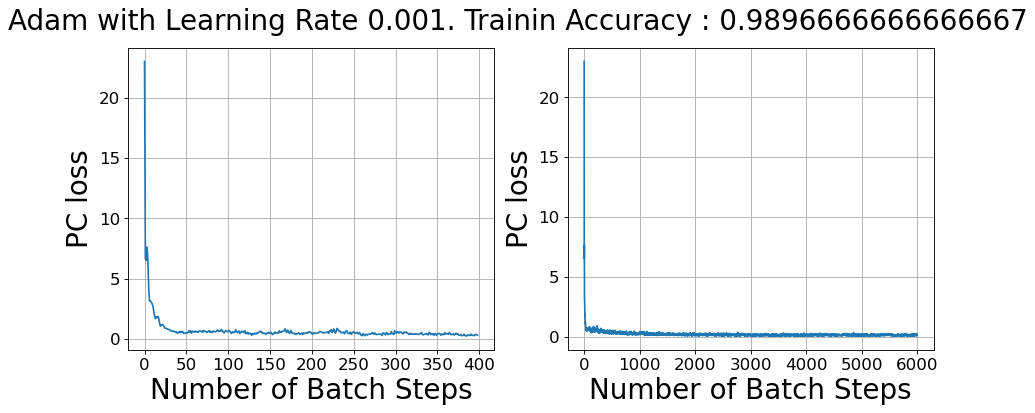

In [6]:
plt.figure(figsize=(13, 5), dpi=80)
plt.subplot(1, 2, 1)
plt.plot(-np.array(pc_train_loss)[1:400])
plt.grid()
plt.ylabel("PC loss", fontsize = 25)
plt.xlabel("Number of Batch Steps", fontsize = 25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.show()

plt.subplot(1, 2, 2)
plt.plot(-np.array(pc_train_loss)[1:6000])
plt.grid()
plt.ylabel("PC loss", fontsize = 25)
plt.xlabel("Number of Batch Steps", fontsize = 25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.suptitle("Adam with Learning Rate 0.001. Trainin Accuracy : {}".format(trn_acc_list[-1]), fontsize = 25)
plt.show()

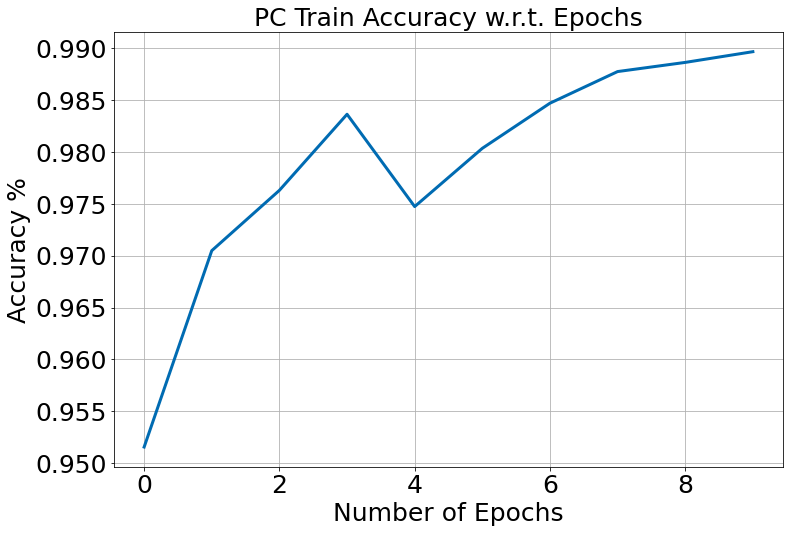

In [7]:
plot_convergence_plot(trn_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'PC Train Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

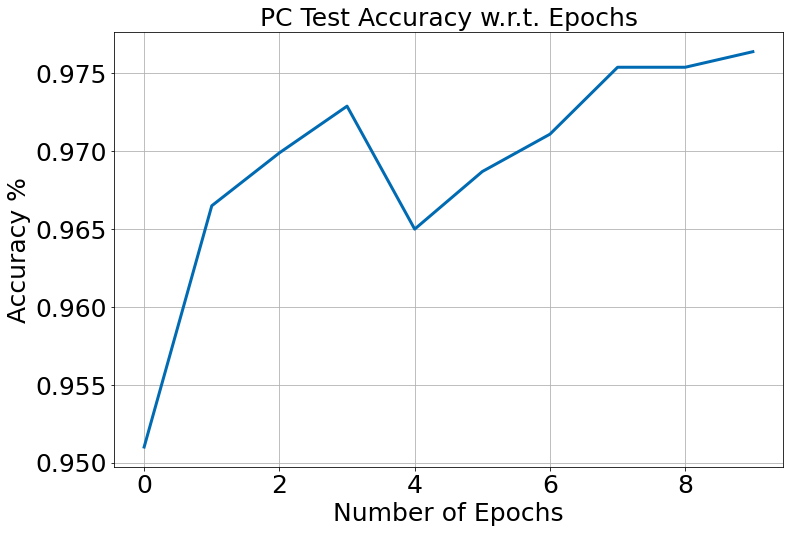

In [8]:
plot_convergence_plot(tst_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'PC Test Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)